[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vQF3Dk9ghr_BjeJoOw1hr-pdS4vRF36k?usp=sharing)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
625/625 [==============================] - 616s 912ms/step - loss: 0.3862 - accuracy: 0.8115 - val_loss: 0.2864 - val_accuracy: 0.8766
Epoch 2/3
625/625 [==============================] - 565s 904ms/step - loss: 0.1961 - accuracy: 0.9235 - val_loss: 0.3222 - val_accuracy: 0.8840
Epoch 3/3
157/157 [==============================] - 48s 304ms/step - loss: 0.3722 - accuracy: 0.8876

Validation Loss: 0.3722
Validation Accuracy: 0.8876
157/157 [==============================] - 46s 274ms/step


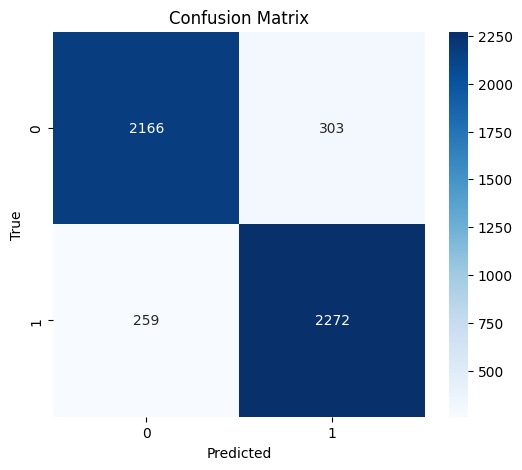

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2469
           1       0.88      0.90      0.89      2531

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [10]:
# Install required libraries
!pip install -q keras-nlp tensorflow_datasets transformers

# Imports
import keras_nlp
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from transformers import TFBertForSequenceClassification, BertTokenizer, create_optimizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load IMDB dataset
train_raw = tfds.load("imdb_reviews", split="train[:80%]", as_supervised=True)
val_raw = tfds.load("imdb_reviews", split="train[80%:]", as_supervised=True)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Preprocessing
def tokenize_dataset(ds, tokenizer, max_len=128):
    input_ids, attention_masks, labels = [], [], []
    for text, label in tfds.as_numpy(ds):
        text = text.decode("utf-8")
        encoding = tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_len,
            return_attention_mask=True,
            return_tensors="np"
        )
        input_ids.append(encoding["input_ids"][0])
        attention_masks.append(encoding["attention_mask"][0])
        labels.append(label)
    return np.array(input_ids), np.array(attention_masks), np.array(labels)

train_input_ids, train_attention_masks, train_labels = tokenize_dataset(train_raw, tokenizer)
val_input_ids, val_attention_masks, val_labels = tokenize_dataset(val_raw, tokenizer)

# Load model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Optimizer & schedule
epochs = 3
batch_size = 32
steps_per_epoch = len(train_input_ids) // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Create tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_input_ids, "attention_mask": train_attention_masks},
    train_labels
)).shuffle(1000).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_input_ids, "attention_mask": val_attention_masks},
    val_labels
)).batch(batch_size)

# Train
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Evaluate
loss, accuracy = model.evaluate(val_ds)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Predict
predictions = model.predict(val_ds).logits
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for _, y in val_ds], axis=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

157/157 [==============================] - 50s 317ms/step


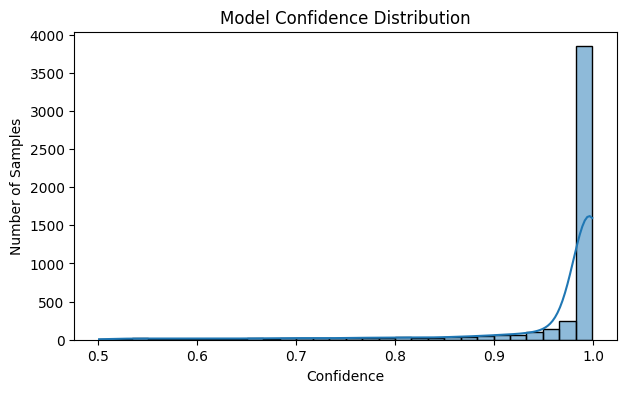

In [14]:
# Predict logits and convert to probabilities
probs = tf.nn.softmax(model.predict(val_ds).logits, axis=1).numpy()
confidences = np.max(probs, axis=1)  # model confidence = highest softmax score

plt.figure(figsize=(7, 4))
sns.histplot(confidences, bins=30, kde=True)
plt.title("Model Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.show()


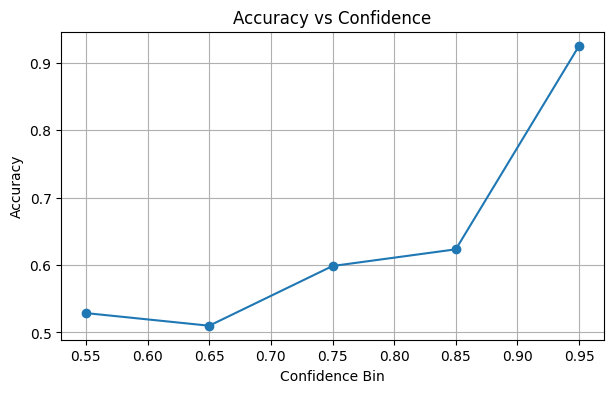

In [15]:
# Bin confidence into 10 buckets and compute accuracy in each
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(confidences, bins) - 1

bin_accuracy = []
for i in range(10):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        acc = np.mean((y_pred[mask] == y_true[mask]))
        bin_accuracy.append(acc)
    else:
        bin_accuracy.append(np.nan)

plt.figure(figsize=(7, 4))
plt.plot(bins[:-1] + 0.05, bin_accuracy, marker='o')
plt.title("Accuracy vs Confidence")
plt.xlabel("Confidence Bin")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [16]:
# Find misclassified indices
misclassified = np.where(y_pred != y_true)[0]




🔍 Misclassified Reviews (Ground Truth ≠ Prediction):

Review: The 1980s TV show, updated with fresh female flesh, and raunchy language. "The Dukes of Hazzard" passed me by; it was not repeated whenever I was in front of the television in either New York or California; or, I probably would have watched. Still, from somewhere (like the clips accompanying this fi...
True Label: Negative
Predicted: Positive
Confidence: 0.84
--------------------------------------------------------------------------------
Review: It seems that the people behind Envy realised that recent comedies - especially ones involving Ben Stiller and to a lesser degree Jack Black - have been situation spoofs, which have steadily declined in originality and generally laughs. I found the sheer absurdity of Zoolander utterly hilarious when...
True Label: Negative
Predicted: Positive
Confidence: 0.90
--------------------------------------------------------------------------------
Review: Since Siskel's death and Ebert's ab

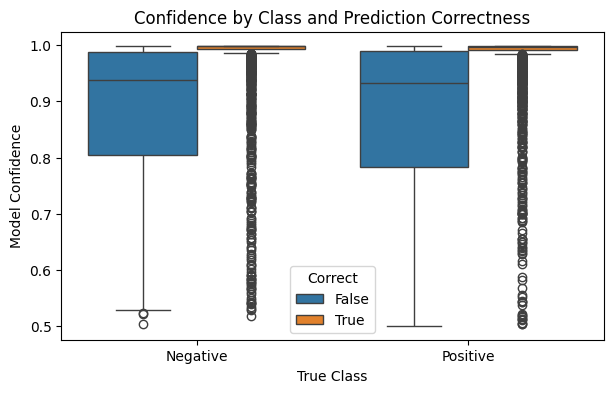

In [17]:
df = {
    "Confidence": confidences,
    "True Label": ["Negative" if y == 0 else "Positive" for y in y_true],
    "Correct": y_pred == y_true
}
import pandas as pd
df = pd.DataFrame(df)

plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x="True Label", y="Confidence", hue="Correct")
plt.title("Confidence by Class and Prediction Correctness")
plt.ylabel("Model Confidence")
plt.xlabel("True Class")
plt.show()